In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lib_file import lib_path
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

In [5]:
df = pd.read_csv("processed_data.csv")
df.head()

,cleaned_text,sentiment
0,device take huge amount battery thought id try...,positive
1,always bought nabis lasted couple year grandki...,negative
2,work great,positive
3,cant beat price bought best buy held well insi...,negative
4,really impressed item pretty slow,negative


In [6]:
df.shape

(10000, 2)

In [7]:
texts = df['cleaned_text'].values.tolist()
labels = [1 if sentiment == "positive" else 0 for sentiment in df['sentiment'].tolist()]

In [8]:
texts[:10]

['device take huge amount battery thought id try seem well top name brand battery',
 'always bought nabis lasted couple year grandkids item bought six year old grandson upgrade nabi lasted month broke two day giving would charge lcd went jump hoop get replaced',
 'work great',
 'cant beat price bought best buy held well inside beefy case bought screen nice sharp however unit randomly shut refuse power back without ever coming contact water drop glad replacement plan affordable',
 'really impressed item pretty slow',
 'excellent price definitely didnt last long popularknown brand',
 'never purchase outer cardboard box frustrationfree battery tightly shrinkwrapped group four need cut wrap begin separate battery pull apart cut little slice wrap around battery figure pull battery little plastic straitjacketeven battery function well hassle unwrapping shrinkwrapped set four battery isnt worth cost saving',
 'think downloaded new apps wait surf web thing slow respond old refurbished ipad bet

In [9]:
labels[:10]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 1]

In [10]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [11]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [12]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    train_predictions = []
    train_actual_labels = []
    running_train_loss = 0.0
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        train_predictions.extend(preds.cpu().tolist())
        train_actual_labels.extend(labels.cpu().tolist())
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        running_train_loss += loss.item()
        optimizer.step()
        scheduler.step()
    return accuracy_score(y_true=train_actual_labels, y_pred=train_predictions), running_train_loss/len(data_loader)

In [13]:
def evaluate(model, data_loader, device):
    model.eval()
    test_predictions = []
    test_actual_labels = []
    running_test_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            running_test_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            test_predictions.extend(preds.cpu().tolist())
            test_actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(y_true=test_actual_labels, y_pred=test_predictions),  running_test_loss/len(data_loader)

In [14]:
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 32
num_epochs = 20
learning_rate = 2e-5

In [15]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)
print(np.array(train_texts).shape, np.array(val_texts).shape, np.array(train_labels).shape, np.array(val_labels).shape)

(8000,) (2000,) (8000,) (2000,)


In [16]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [19]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [20]:
history = {
    'Train_Accuracy':[],
    'Train_Loss':[],
    'Val_Accuracy':[],
    'Val_Loss':[]
}

for epoch in range(num_epochs):
    train_accuracy_, train_loss_ = train(model, train_dataloader, optimizer, scheduler, device)
    val_accuracy_, val_loss_ = evaluate(model, val_dataloader, device)

    print(f"[{epoch+1:>3d}/{num_epochs:>3d}], train_accuracy:{train_accuracy_:>3f}, train_loss:{train_loss_:>3f}, val_accuracy:{val_accuracy_:>3f}, val_loss:{val_loss_:>3f}")
    history['Train_Accuracy'].append(train_accuracy_)
    history['Train_Loss'].append(train_loss_)
    history['Val_Accuracy'].append(val_accuracy_)
    history['Val_Loss'].append(val_loss_)

[  1/ 20], train_accuracy:0.859125, train_loss:0.330565, val_accuracy:0.940000, val_loss:0.159331
[  2/ 20], train_accuracy:0.950250, train_loss:0.136335, val_accuracy:0.967500, val_loss:0.113953
[  3/ 20], train_accuracy:0.974375, train_loss:0.078232, val_accuracy:0.966500, val_loss:0.104547
[  4/ 20], train_accuracy:0.986625, train_loss:0.041734, val_accuracy:0.974000, val_loss:0.090138
[  5/ 20], train_accuracy:0.990250, train_loss:0.029529, val_accuracy:0.965500, val_loss:0.132391
[  6/ 20], train_accuracy:0.994375, train_loss:0.018606, val_accuracy:0.972000, val_loss:0.121864
[  7/ 20], train_accuracy:0.991875, train_loss:0.021662, val_accuracy:0.973000, val_loss:0.128505
[  8/ 20], train_accuracy:0.994875, train_loss:0.017064, val_accuracy:0.968500, val_loss:0.132230
[  9/ 20], train_accuracy:0.995125, train_loss:0.015097, val_accuracy:0.969500, val_loss:0.144099
[ 10/ 20], train_accuracy:0.996125, train_loss:0.013765, val_accuracy:0.977500, val_loss:0.108519
[ 11/ 20], train_acc

In [21]:
PATH = "models/BERTClassification_model.pt"
torch.save(model.state_dict(),PATH)

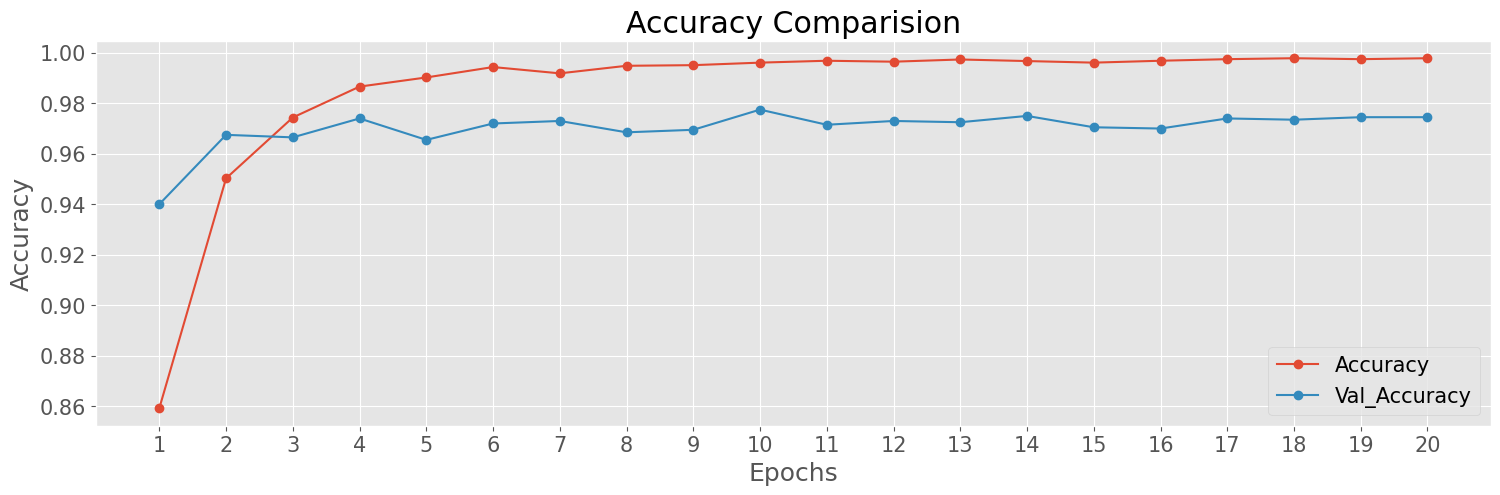

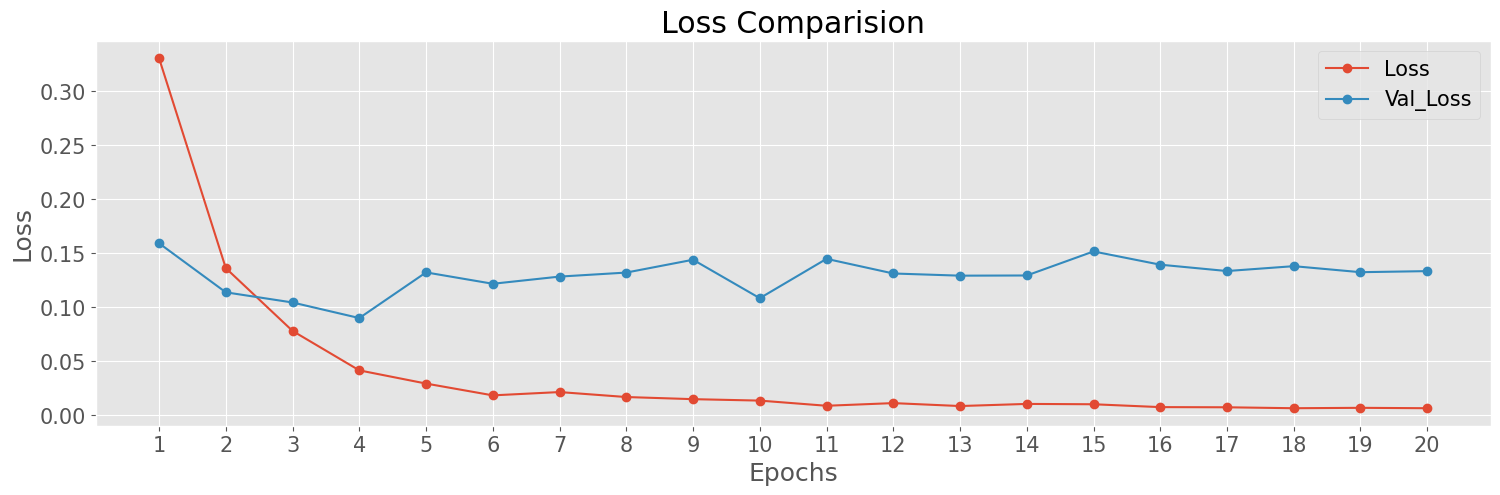

In [22]:
with plt.style.context(style="ggplot"):
    plt.figure(figsize=(18,5))
    plt.rcParams['font.size'] = 15
    plt.plot([str(i) for i in range(1, len(history['Train_Accuracy'])+1)], history['Train_Accuracy'],label="Accuracy", marker='o')
    plt.plot([str(i) for i in range(1, len(history['Val_Accuracy'])+1)], history['Val_Accuracy'],label="Val_Accuracy", marker='o')
    plt.title(label="Accuracy Comparision")
    plt.xlabel(xlabel="Epochs")
    plt.ylabel(ylabel="Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(18,5))
    plt.rcParams['font.size'] = 15
    plt.plot([str(i) for i in range(1, len(history['Train_Loss'])+1)], history['Train_Loss'],label="Loss", marker='o')
    plt.plot([str(i) for i in range(1, len(history['Val_Loss'])+1)], history['Val_Loss'],label="Val_Loss", marker='o')
    plt.title(label="Loss Comparision")
    plt.xlabel(xlabel="Epochs")
    plt.ylabel(ylabel="Loss")
    plt.legend()
    plt.show()

In [23]:
def prediction_(model, data_loader, device):
    model.eval()
    test_predictions = []
    test_actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            test_predictions.extend(preds.cpu().tolist())
            test_actual_labels.extend(labels.cpu().tolist())
    return test_actual_labels, test_predictions

In [24]:
true, predicted = prediction_(model, val_dataloader, device)

In [25]:
print(true)

[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 

In [26]:
print(predicted)

[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 

### Result Analysis

In [27]:
class_labels = ['Negative', 'Positive']

In [28]:
bert_accuracy=accuracy_score(y_true=true,y_pred=predicted)
print("Validation accuracy of BERT model is {:.2f}%".format(bert_accuracy*100.0))

Validation accuracy of BERT model is 97.45%


In [29]:
print(classification_report(y_true=true,y_pred=predicted,target_names=class_labels))

              precision    recall  f1-score   support

    Negative       0.97      0.98      0.97      1000
    Positive       0.98      0.96      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



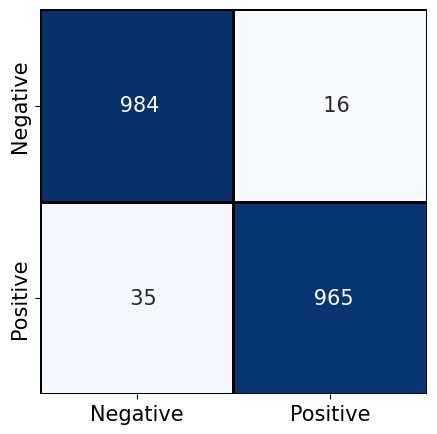

In [30]:
plt.figure(figsize=(5,5))
plt.rcParams['font.size'] = 15
sns.heatmap(data=confusion_matrix(y_true=true,y_pred=predicted),
            annot=True,
            cmap=plt.cm.Blues,
            cbar=False,
            fmt='4d',
            linecolor='black',
            linewidth=2,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.show()

## Thank You

---